In [15]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import multiprocessing
import time
from datetime import timedelta

#Get total no of avaliable threads
nthreads = multiprocessing.cpu_count()

In [30]:
data = pd.read_csv('output2_gg.csv', delimiter=';')
print ('finish loading from csv ')
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))
print ('\nList of features in dataset:')
for col in data.columns:
   print(col)

finish loading from csv 
Size of data: (773417, 58)
Number of events: 773417
Number of columns: 58

List of features in dataset:
year
e_met_mT_per_M
m_met_mT_per_M
mPt_Per_e_m_Mass
ePt_Per_e_m_Mass
e_m_Mass
emPt
emEta
mEta
eEta
j1Pt
j2Pt
j1Eta
j2Eta
DeltaEta_e_m
DeltaPhi_e_m
DeltaEta_e_j1
DeltaPhi_e_j1
DeltaEta_m_j1
DeltaPhi_m_j1
DeltaEta_e_j2
DeltaPhi_e_j2
DeltaEta_m_j2
DeltaPhi_m_j2
DeltaEta_em_j1
DeltaPhi_em_j1
DeltaEta_em_j2
DeltaPhi_em_j2
DeltaEta_j1_j2
DeltaPhi_j1_j2
Zeppenfeld
Zeppenfeld_ver2
Zeppenfeld_ver3
j1_j2_mass
DeltaPhi_em_j1j2
DeltaEta_em_j1j2
m_met_mT
e_met_mT
DeltaPhi_e_met
DeltaPhi_m_met
MetEt
e_m_PZeta
R_pT
pT_cen
pT_cen_ver2
pT_cen_ver3
cen
DeltaR_e_m
weight
DeltaR_em_j1
DeltaR_em_j2
DeltaR_j1_j2
DeltaR_em_j1j2
DeltaR_e_j1
DeltaR_m_j1
DeltaR_e_j2
DeltaR_m_j2
label


In [31]:
data['label'] = data.label.astype('category')

# split data into X and y
X = data
Y = data['label']

# split data into train and test sets
seed = 123
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#Rescale signal weight to bkg weight
sig_to_bkg_ratio = X_train.loc[X_train['label'] == 0]['weight'].sum()/X_train.loc[X_train['label'] == 1]['weight'].sum()

Time spent on training 0:00:33.566843


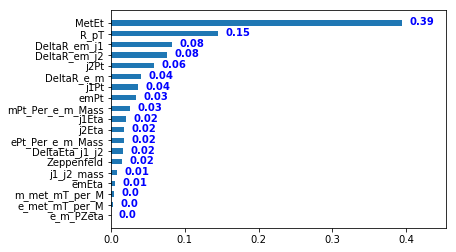

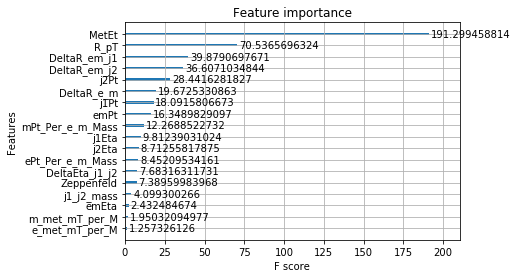

AUC of training set: 0.925457
AUC of testing set: 0.924700


In [33]:
# Train with the default model to select features
#feature_names = ['e_met_mT_per_M', 'm_met_mT_per_M', 'mPt_Per_e_m_Mass', 'ePt_Per_e_m_Mass', 'emPt', 'MetEt', 'DeltaR_e_m', 'e_m_PZeta', 'emEta'] 
#feature_names = ['e_met_mT_per_M', 'm_met_mT_per_M', 'mPt_Per_e_m_Mass', 'ePt_Per_e_m_Mass', 'emPt', 'MetEt', 'DeltaR_e_m', 'e_m_PZeta', 'emEta', 'j1Pt', 'DeltaR_em_j1', 'j1Eta', 'R_pT']
feature_names = ['e_met_mT_per_M', 'm_met_mT_per_M', 'mPt_Per_e_m_Mass', 'ePt_Per_e_m_Mass', 'emPt', 'MetEt', 'DeltaR_e_m', 'e_m_PZeta', 'emEta', 'j1Pt', 'DeltaR_em_j1', 'j1Eta', 'R_pT', 'j2Pt', 'DeltaR_em_j2', 'j2Eta', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Zeppenfeld']

tic = time.time()
model = model = xgb.XGBClassifier(n_jobs=nthreads, scale_pos_weight=sig_to_bkg_ratio)
model.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', verbose=False)
toc = time.time()
print "Time spent on training %s"%str(timedelta(seconds=toc - tic))

#Check the feature ranking
importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
 plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

#Check also the auc
results = model.evals_result()
print "AUC of training set: %f"%results['validation_0']['auc'][-1]
print "AUC of testing set: %f"%results['validation_1']['auc'][-1]

#Modify features accordingly and run again

In [4]:
## Hyperparameter optimization using RandomizedSearchCV
params={
 "learning_rate"    : [ 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
 "subsample"        : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
 "reg_lambda"           : [ 0.1, 1.0, 5.0, 10.0 ],            
 "reg_alpha "           : [ 0, 0.1, 1.0, 5.0 ],           
 "scale_pos_weight" : [sig_to_bkg_ratio],   
}

model = xgb.XGBClassifier(n_jobs=nthreads)
random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=8,scoring='roc_auc',n_jobs=nthreads,cv=3,verbose=3)
tic = time.time()
random_search.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_metric='auc')
toc = time.time()
print "Time spent on hyperparameter optimization %s"%str(timedelta(seconds=toc - tic))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   4 out of  24 | elapsed:  2.9min remaining: 14.5min
[Parallel(n_jobs=24)]: Done  13 out of  24 | elapsed:  6.9min remaining:  5.8min
[Parallel(n_jobs=24)]: Done  22 out of  24 | elapsed:  8.8min remaining:   48.1s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  8.9min finished
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-xgboost/0.82-nmpfii2/lib/python2.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-xgboost/0.82-nmpfii2/lib/python2.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time spent on hyperparameter optimization 0:10:06.578019


In [5]:
random_search.cv_results_

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by d

{'mean_fit_time': array([280.83581392,  71.65810863, 155.57915235, 345.78622103,
        175.04250741, 378.48524245, 322.58030272, 282.44074202]),
 'mean_score_time': array([1.8073024 , 1.11336565, 1.33235256, 0.99262794, 1.18877101,
        0.6043973 , 0.96087472, 0.71723898]),
 'mean_test_score': array([0.93103631, 0.92744862, 0.9289498 , 0.92935315, 0.92878399,
        0.93048627, 0.93098135, 0.93056123]),
 'mean_train_score': array([0.93357859, 0.92819187, 0.93023772, 0.93195629, 0.92997532,
        0.932744  , 0.93493129, 0.93287268]),
 'param_colsample_bytree': masked_array(data=[0.8, 0.6, 0.7, 0.6, 0.8, 0.9, 0.7, 0.6],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.3, 0.3, 0.3, 0.4, 0.2, 0.0, 0.2, 0.4],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_a

In [6]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.2,
       max_delta_step=0, max_depth=8, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=24, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_alpha =1.0, reg_lambda=10.0, scale_pos_weight=3.151886734544248,
       seed=None, silent=True, subsample=0.9)

In [7]:
# Retrain with the best model
tic = time.time()
model = xgb.XGBClassifier(alpha =0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, reg_lambda=10.0, learning_rate=0.15,
       max_delta_step=0, max_depth=8, min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=24, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       scale_pos_weight=3.151886734544248, seed=None,
       silent=True, subsample=0.9)
model.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', verbose=False)
toc = time.time()
print "Time spent on training %s"%str(timedelta(seconds=toc - tic))

Time spent on training 0:01:21.816371


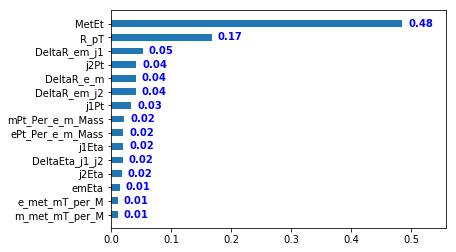

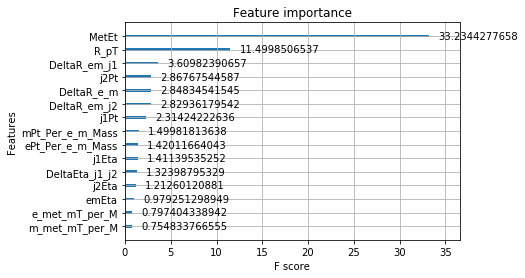

In [8]:
#Check the feature ranking again with the best model

importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
 plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

AUC of training set: 0.933971
AUC of testing set: 0.931553


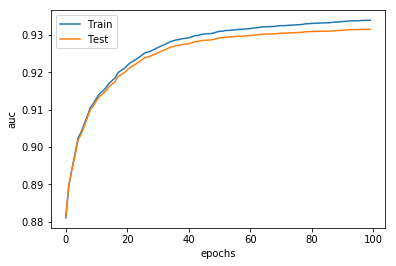

In [9]:
#Get AUC of final model for both training and testing set to avoid overtraining
results = model.evals_result()
print "AUC of training set: %f"%results['validation_0']['auc'][-1]
print "AUC of testing set: %f"%results['validation_1']['auc'][-1]
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()
# train = xgb.DMatrix(data=X_train[feature_names],label=X_train.label.cat.codes,
#                    feature_names=feature_names, weight=X_train['weight'])
# test = xgb.DMatrix(data=X_test[feature_names],label=X_test.label.cat.codes,
#                    feature_names=feature_names, weight=X_test['weight'])
# booster = model.get_booster()
# print(booster.eval(test))
# print(booster.eval(train))
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])

predictions_sig_train = model.predict_proba(X_train.loc[X_train['label'] == 1][feature_names])
predictions_bkg_train = model.predict_proba(X_train.loc[X_train['label'] == 0][feature_names])

# sklearn auc does not work on negative weights
# y_pred = model.predict_proba(X_test[feature_names])
# print roc_auc_score(y_test, y_pred[:,1], sample_weight=X_test['weight'], pos_label = 1)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


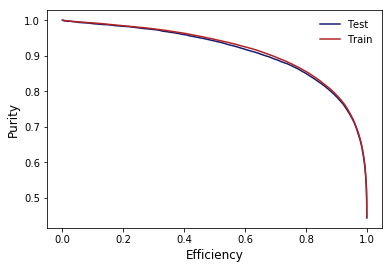

In [11]:
#Additional overtraining test
cuts = np.linspace(0,1,500);
#testing set
nsignal_test = np.zeros(len(cuts));
nbackground_test = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal_test[i] = len(np.where(predictions_sig_test[:,1] > cut)[0]);
    nbackground_test[i] = len(np.where(predictions_bkg_test[:,1] > cut)[0]);
#training set
nsignal_train = np.zeros(len(cuts));
nbackground_train = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal_train[i] = len(np.where(predictions_sig_train[:,1] > cut)[0]);
    nbackground_train[i] = len(np.where(predictions_bkg_train[:,1] > cut)[0]);
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal_test/len(X_test[X_test.label == 1]),nsignal_test/(nsignal_test + nbackground_test),'-',color='midnightblue', label='Test');
plt.plot(nsignal_train/len(X_train[X_train.label == 1]),nsignal_train/(nsignal_train + nbackground_train),'-',color='firebrick', label='Train');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

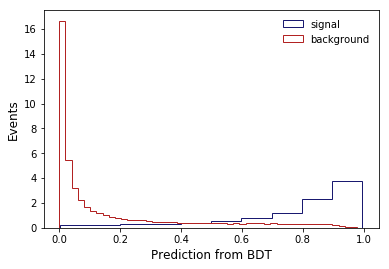

In [10]:
# plot signal and background separately
plt.figure();
plt.hist(predictions_sig_test[:,1],density=True,
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

In [12]:
#Save model if everything looks good
model_out_file = "model_GG_2jets.json"
model.save_model(model_out_file)

In [14]:
#Load and predict from model
model_load = xgb.XGBClassifier()
model_load.load_model(model_out_file)
predictions = model_load.predict_proba(X_test[feature_names])
print predictions

[[0.11725003 0.88275   ]
 [0.97172993 0.02827005]
 [0.9947172  0.00528282]
 ...
 [0.05969727 0.9403027 ]
 [0.91208166 0.08791832]
 [0.97825897 0.02174105]]
